Import packages

In [1]:
import tensorflow as tf
from tensorflow.keras import layers as tfl
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.initializers import glorot_uniform
from keras import backend as K
import matplotlib.pyplot as plt
import os
cwd = os.getcwd()
directory = cwd.replace("\\", "/")[:-9]

Define f1_score

In [2]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

Prefetch the datasets

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# It is assumed that the training and testing directories contain the same distribution of data. 
# Hence the validation dataset is sampled from the training set.
train_dataset, validation_dataset = image_dataset_from_directory(directory+"/images/training/",
                                                                 shuffle=True,
                                                                 validation_split = 0.2,
                                                                 subset = 'both',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 seed=42)

test_dataset = image_dataset_from_directory(directory+"/images/testing/",
                                            shuffle=False,
                                            batch_size=597,
                                            image_size=IMG_SIZE,
                                            seed=42)

class_names = train_dataset.class_names
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

print(f'The class names are: {class_names}')

Found 2392 files belonging to 2 classes.
Using 1914 files for training.
Using 478 files for validation.
Found 597 files belonging to 2 classes.
The class names are: ['flip', 'notflip']


Define the preprocessing function

In [4]:
tf.random.set_seed(42)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

First attempt: Only fine tune the top of the base model

In [5]:
def flip_model(image_shape=IMG_SIZE, data_augmentation=tf.identity, include_top = True):
    ''' Define a keras model for binary classification making use of MobileNetV2
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
        Keras model instance
    '''
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape = input_shape,
                                                   include_top = include_top,
                                                   weights = 'imagenet')
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape) 
    x = data_augmentation(inputs)
    x = preprocess_input(x) 
    x = base_model(x, training=False) 
    x = tfl.GlobalAveragePooling2D()(x) 
    x = tfl.Dropout(0.2)(x)
    outputs = tfl.Dense(1, activation = 'linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

mobilenetv2_model = flip_model()

Compile the model

In [6]:
mobilenetv2_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),
                          loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                          metrics = ['accuracy', f1_score])

Train the model

In [7]:
initial_epochs = 5
history = mobilenetv2_model.fit(train_dataset, 
                                validation_data=validation_dataset, 
                                epochs=initial_epochs)

Epoch 1/5
60/60 [==============================] - 185s 3s/step - loss: 0.6274 - accuracy: 0.6108 - f1_score: 0.5160 - val_loss: 0.5063 - val_accuracy: 0.7678 - val_f1_score: 0.7528
Epoch 2/5
60/60 [==============================] - 143s 2s/step - loss: 0.4896 - accuracy: 0.7440 - f1_score: 0.7000 - val_loss: 0.4178 - val_accuracy: 0.8264 - val_f1_score: 0.8059
Epoch 3/5
60/60 [==============================] - 119s 2s/step - loss: 0.4112 - accuracy: 0.8036 - f1_score: 0.7816 - val_loss: 0.3675 - val_accuracy: 0.8598 - val_f1_score: 0.8469
Epoch 4/5
60/60 [==============================] - 264s 4s/step - loss: 0.3702 - accuracy: 0.8229 - f1_score: 0.8011 - val_loss: 0.3302 - val_accuracy: 0.8891 - val_f1_score: 0.8838
Epoch 5/5
60/60 [==============================] - 215s 4s/step - loss: 0.3335 - accuracy: 0.8574 - f1_score: 0.8470 - val_loss: 0.3041 - val_accuracy: 0.8891 - val_f1_score: 0.8824


Plot the training history

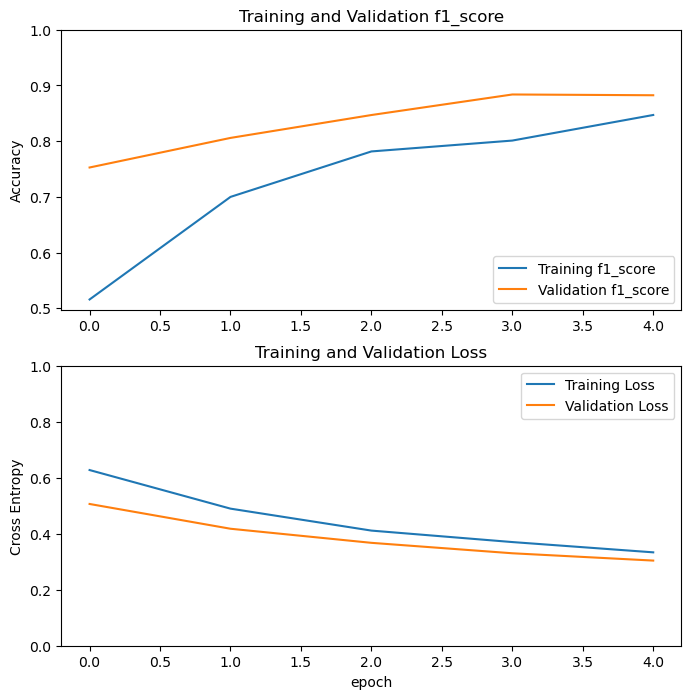

In [8]:
score = history.history['f1_score']
val_score = history.history['val_f1_score']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(score, label='Training f1_score')
plt.plot(val_score, label='Validation f1_score')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation f1_score')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

Second attempt: Fine tune the last few dozens of layers

In [9]:
base_model = mobilenetv2_model.layers[4]
base_model.trainable = True
print(f'Number of layers in the base model: {len(base_model.layers)}')

Number of layers in the base model: 154


Fine-tune from this layer onwards

In [10]:
fine_tune_at = 120
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Compile the model

In [11]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.0001,
                                                             decay_steps = len(train_dataset), 
                                                             decay_rate = 0.8, 
                                                             staircase = False
                                                             )
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
metrics = ['accuracy', f1_score]

mobilenetv2_model.compile(loss=loss_function,
                          optimizer = optimizer,
                          metrics=metrics
                          )

Train the model

In [12]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = mobilenetv2_model.fit(train_dataset,
                                     epochs=total_epochs,
                                     initial_epoch=history.epoch[-1],
                                     validation_data=validation_dataset
                                     )

mobilenetv2_model.save_weights('./checkpoints/MobileNetV2')

Epoch 5/10
60/60 [==============================] - 278s 4s/step - loss: 0.3616 - accuracy: 0.8485 - f1_score: 0.8254 - val_loss: 0.1067 - val_accuracy: 0.9623 - val_f1_score: 0.9628
Epoch 6/10
60/60 [==============================] - 273s 4s/step - loss: 0.0771 - accuracy: 0.9749 - f1_score: 0.9761 - val_loss: 0.0344 - val_accuracy: 0.9958 - val_f1_score: 0.9958
Epoch 7/10
60/60 [==============================] - 233s 4s/step - loss: 0.0162 - accuracy: 0.9958 - f1_score: 0.9963 - val_loss: 0.0262 - val_accuracy: 0.9916 - val_f1_score: 0.9911
Epoch 8/10
60/60 [==============================] - 285s 5s/step - loss: 0.0095 - accuracy: 0.9979 - f1_score: 0.9978 - val_loss: 0.0142 - val_accuracy: 0.9979 - val_f1_score: 0.9978
Epoch 9/10
60/60 [==============================] - 370s 6s/step - loss: 0.0048 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.0106 - val_accuracy: 0.9979 - val_f1_score: 0.9978
Epoch 10/10
60/60 [==============================] - 306s 5s/step - loss: 0.0026 - ac

Plot the fine-tuning

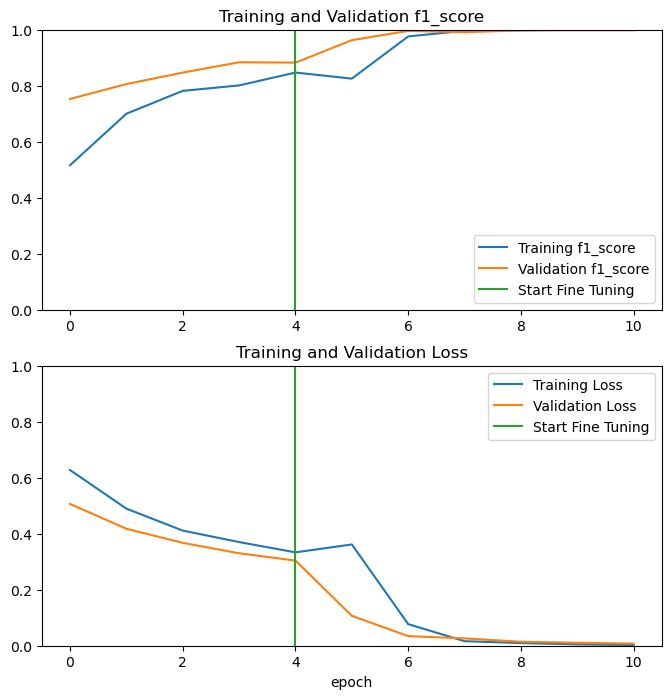

In [13]:
score += history_fine.history['f1_score']
val_score += history_fine.history['val_f1_score']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(score, label='Training f1_score')
plt.plot(val_score, label='Validation f1_score')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation f1_score')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

Evaluate on the test set

In [14]:
print('Evaluating the model on the test set\n')
mobilenetv2_model.evaluate(test_dataset)
test_predictions = mobilenetv2_model.predict(test_dataset)

Evaluating the model on the test set

1/1 [==============================] - 44s 44s/step


Verify that the weights can be loaded

In [15]:
loaded_model = flip_model()
loaded_model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                     metrics = ['accuracy', f1_score])
loaded_model.load_weights('./checkpoints/MobileNetV2')
print('Evaluating the model on the test set\n')
loaded_model.evaluate(test_dataset)
test_predictions = loaded_model.predict(test_dataset)

Evaluating the model on the test set

1/1 [==============================] - 48s 48s/step
